LABEL: 100%|██████████| 5890/5890 [00:00<00:00, 654370.53it/s]


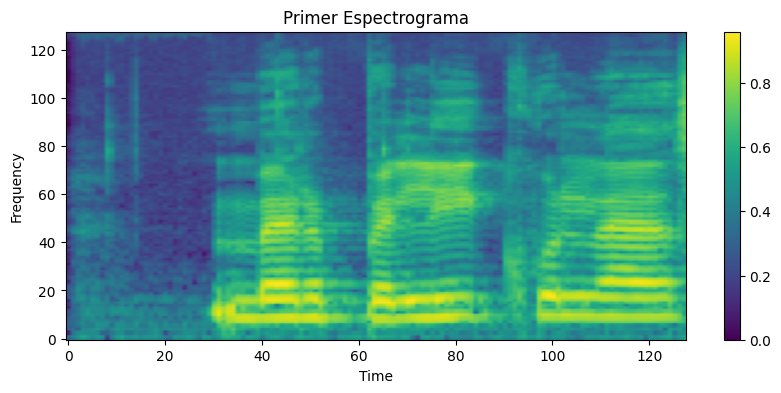

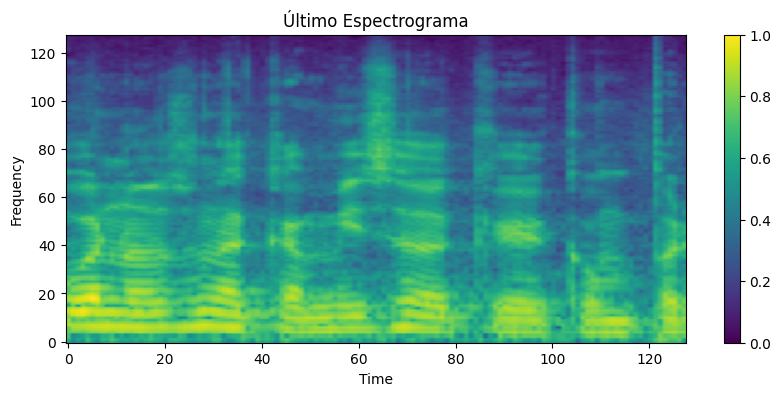

Epoch 1/50
148/148 [==============================] - 4s 25ms/step - loss: 0.9509 - accuracy: 0.5216 - precision: 0.4958 - recall: 0.4966 - f1_score: 0.4962 - val_loss: 0.6912 - val_accuracy: 0.5068 - val_precision: 0.4919 - val_recall: 0.6397 - val_f1_score: 0.5561
Epoch 2/50
148/148 [==============================] - 3s 22ms/step - loss: 0.8887 - accuracy: 0.5420 - precision: 0.5175 - recall: 0.5092 - f1_score: 0.5133 - val_loss: 0.6902 - val_accuracy: 0.5238 - val_precision: 0.5058 - val_recall: 0.6098 - val_f1_score: 0.5530
Epoch 3/50
148/148 [==============================] - 3s 22ms/step - loss: 0.8465 - accuracy: 0.5539 - precision: 0.5300 - recall: 0.5262 - f1_score: 0.5281 - val_loss: 0.6961 - val_accuracy: 0.5238 - val_precision: 0.5059 - val_recall: 0.6028 - val_f1_score: 0.5501
Epoch 4/50
148/148 [==============================] - 3s 22ms/step - loss: 0.8255 - accuracy: 0.5624 - precision: 0.5399 - recall: 0.5235 - f1_score: 0.5316 - val_loss: 0.6946 - val_accuracy: 0.5467 

In [4]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torchaudio
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Resizing, Conv2D, Dropout, BatchNormalization, MaxPool2D, Flatten, Dense, Input, LeakyReLU
from tqdm import tqdm
import tensorflow_addons as tfa

F1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

# Configuración de parámetros
class Config:
    def __init__(self, architecture='CNN_LF', epochs=50, sample_rate=None, time=5, n_splits=5, window_size=5):
        self.architecture = architecture
        self.epochs = epochs
        self.sample_rate = sample_rate
        self.time = time
        self.n_splits = n_splits
        self.window_size = window_size

# Funciones de Preprocesamiento
def load_audio_data(directory, window_size, sample_rate):
    audio_dict = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            waveform, sr = torchaudio.load(os.path.join(directory, file_name))
            if sample_rate is None:
                sample_rate = sr
            num_windows = int(waveform.shape[1] / (window_size * sample_rate))
            for i in range(num_windows):
                start = i * window_size * sample_rate
                end = (i + 1) * window_size * sample_rate
                audio_dict[f"{file_name}_{i}"] = waveform[:, start:end].numpy()
    return audio_dict, sample_rate

def preprocess_audio(audio_dict, sample_rate):
    audio_dict = copy.deepcopy(audio_dict)
    n_mels = 128
    n_fft = int(sample_rate * 0.029)
    hop_length = int(sample_rate * 0.010)
    win_length = int(sample_rate * 0.025)

    for filename, waveform in tqdm(audio_dict.items(), desc='MELSPECTROGRAM'):
        waveform = torch.from_numpy(waveform)
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length)(waveform)
        spec = torchaudio.transforms.AmplitudeToDB()(spec)
        spec = spec.numpy()
        spec = (spec - spec.min()) / (spec.max() - spec.min())
        audio_dict[filename] = spec
    return audio_dict

def pad_and_crop_spectrograms(spectrograms, target_shape=(128, 128)):
    padded_spectrograms = []
    for spec in spectrograms:
        if spec.shape[0] > target_shape[0]]:
            spec = spec[:target_shape[0], :]
        if spec.shape[1] > target_shape[1]]:
            spec = spec[:, :target_shape[1]]
        
        pad_width = [(0, max(0, target_shape[0] - spec.shape[0])), 
                     (0, max(0, target_shape[1] - spec.shape[1]))]
        
        padded_spec = np.pad(spec, pad_width, mode='constant')
        padded_spectrograms.append(padded_spec)
    return np.array(padded_spectrograms)

def train_test_split_audio(audio_dict):
    df = pd.read_csv('Dataset.csv', usecols=['Participant_ID', 'PHQ-9 Score'], dtype={1: str})
    df['labels'] = np.zeros([len(df),], dtype=int)
    df.loc[df['PHQ-9 Score'] < 10, 'labels'] = 0
    df.loc[df['PHQ-9 Score'] >= 10, 'labels'] = 1

    labels = df.set_index('Participant_ID').to_dict()['labels']

    X, Y = [], []
    for filename, data in tqdm(audio_dict.items(), 'LABEL'):
        ID = filename[:3]
        if ID in labels:
            dep = 0 if labels[ID] == 0 else 1
            [X.append(x) for x in data]
            [Y.append(dep) for x in data]

    X = pad_and_crop_spectrograms(X)
    Y = np.array(Y)

    X = X[..., np.newaxis]
    return X, Y

# Definición de Modelos
def build_model(config):
    if config.architecture == 'CNN_LF':
        return build_CNN_LF_model()
    elif config.architecture == 'reduced_model':
        return build_reduced_model()
    elif config.architecture == 'Spectro_CNN':
        return build_Spectro_CNN_model()
    else:
        raise ValueError("Arquitectura no soportada")

def build_CNN_LF_model(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Resizing(128, 128, input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(15, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    return model

def build_reduced_model(input_shape=(128, 128, 1)):
    model = Sequential([
        BatchNormalization(name='batch_normalization_9'),
        Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=input_shape, name='conv2d_6'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_9'),
        BatchNormalization(name='batch_normalization_10'),
        Conv2D(8, (3, 3), padding='same', name='conv2d_7'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_10'),
        BatchNormalization(name='batch_normalization_11'),
        Flatten(name='flatten_6'),
        Dense(32, name='dense_6'),
        LeakyReLU(alpha=0.01, name='leaky_re_lu_11'),
        Dense(1, activation='sigmoid', name='dense_7')
    ])
    return model

def build_Spectro_CNN_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    for _ in range(31):
        x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Plot de Espectrogramas
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Función para calcular la especificidad
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Entrenamiento y Evaluación
def train_and_evaluate_model(model, X_train, Y_train, X_test, Y_test, config):
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=["accuracy", 'Precision', 'Recall', F1])
    model.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_test, Y_test))
    results = model.evaluate(X_test, Y_test)
    
    # Predicciones para métricas adicionales
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = results[1]
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    specificity = specificity_score(Y_test, Y_pred)
    
    return results[0], accuracy, precision, recall, f1, specificity

# Ejecución Principal
def main(architecture='CNN_LF', epochs=50, n_splits=5, window_size=5):
    config = Config(architecture=architecture, epochs=epochs, n_splits=n_splits, window_size=window_size)
    directory = './SM-27'
    
    audio_dict, sample_rate = load_audio_data(directory, config.window_size, config.sample_rate)
    audio_dict = preprocess_audio(audio_dict, sample_rate)
    X, Y = train_test_split_audio(audio_dict)

    # Plot del primer y último espectrograma
    plot_spectrogram(X[0].squeeze(), "Primer Espectrograma")
    plot_spectrogram(X[-1].squeeze(), "Último Espectrograma")
    
    kfold = KFold(n_splits=config.n_splits, shuffle=True)

    results = []
    
    for fold, (train_index, test_index) in enumerate(kfold.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        model = build_model(config)
        fold_results = train_and_evaluate_model(model, X_train, Y_train, X_test, Y_test, config)
        results.append(fold_results)
    
    results = np.array(results)
    avg_results = np.mean(results, axis=0)
    
    print("\nResults per fold:")
    for i, result in enumerate(results, 1):
        print(f"Fold {i} - Loss: {result[0]}, Accuracy: {result[1]}, Precision: {result[2]}, Recall: {result[3]}, F1-score: {result[4]}, Specificity: {result[5]}")
    
    print("\nAverage results:")
    print(f"Loss: {avg_results[0]}, Accuracy: {avg_results[1]}, Precision: {avg_results[2]}, Recall: {avg_results[3]}, F1-score: {avg_results[4]}, Specificity: {avg_results[5]}")

if __name__ == "__main__":
    main()
